# Estimativa Salarial Usando Modelos de Regressão

## Imports

In [35]:
# Bibliotecas padrão
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

# Scikit-learn: Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Scikit-learn: Divisão de dados
from sklearn.model_selection import GridSearchCV, train_test_split

# Scikit-learn: Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Scikit-learn: Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-learn: Seleção de features
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_regression,
)

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Scikit-learn: Inspeção de modelos
from sklearn.inspection import PartialDependenceDisplay

## Dataset

In [2]:
data_path = Path("data_cleaned_2021.csv")
assert data_path.exists(), f"Arquivo não encontrado: {data_path}"

df = pd.read_csv(data_path)
assert not df.empty, "DataFrame está vazio"

## Análise inicial


In [4]:
df.shape

(742, 42)

In [5]:
#show all columns
pd.set_option('display.max_columns', None)
#show all rows
df.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),company_txt,Job Location,Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Albuquerque, NM","Goleta, CA",501 - 1000,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research,NM,48,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,data scientist,na,M
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Linthicum, MD","Baltimore, MD",10000+,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System,MD,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,data scientist,na,M
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL","Clearwater, FL",501 - 1000,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4,FL,11,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,data scientist,na,M
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA","Richland, WA",1001 - 5000,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5,PNNL,WA,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,data scientist,na,na
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY","New York, NY",51 - 200,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions,NY,23,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,data scientist,na,na


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               742 non-null    int64  
 1   Job Title           742 non-null    object 
 2   Salary Estimate     742 non-null    object 
 3   Job Description     742 non-null    object 
 4   Rating              742 non-null    float64
 5   Company Name        742 non-null    object 
 6   Location            742 non-null    object 
 7   Headquarters        742 non-null    object 
 8   Size                742 non-null    object 
 9   Founded             742 non-null    int64  
 10  Type of ownership   742 non-null    object 
 11  Industry            742 non-null    object 
 12  Sector              742 non-null    object 
 13  Revenue             742 non-null    object 
 14  Competitors         742 non-null    object 
 15  Hourly              742 non-null    int64  
 16  Employer

In [7]:
df.describe()

,index,Rating,Founded,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,469.129380,3.618868,1837.154987,0.032345,0.022911,74.754717,128.214286,101.484501,47.524259,0.528302,0.225067,0.237197,0.522911,0.512129,0.088949,0.039084,0.052561,0.072776,0.097035,0.167116,0.199461,0.075472,0.013477,0.049865,0.018868
std,279.793117,0.801210,497.183763,0.177034,0.149721,30.945892,45.128650,37.482449,53.839080,0.499535,0.417908,0.425651,0.499812,0.500190,0.284862,0.193925,0.223305,0.259944,0.296205,0.373331,0.399865,0.264329,0.115384,0.217813,0.136150
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,15.500000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.500000,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,472.500000,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,25.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,707.750000,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,60.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,955.000000,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isnull().sum() * 100 / df.shape[0]

index                 0.0
Job Title             0.0
Salary Estimate       0.0
Job Description       0.0
Rating                0.0
Company Name          0.0
Location              0.0
Headquarters          0.0
Size                  0.0
Founded               0.0
Type of ownership     0.0
Industry              0.0
Sector                0.0
Revenue               0.0
Competitors           0.0
Hourly                0.0
Employer provided     0.0
Lower Salary          0.0
Upper Salary          0.0
Avg Salary(K)         0.0
company_txt           0.0
Job Location          0.0
Age                   0.0
Python                0.0
spark                 0.0
aws                   0.0
excel                 0.0
sql                   0.0
sas                   0.0
keras                 0.0
pytorch               0.0
scikit                0.0
tensor                0.0
hadoop                0.0
tableau               0.0
bi                    0.0
flink                 0.0
mongo                 0.0
google_an   

<Axes: >

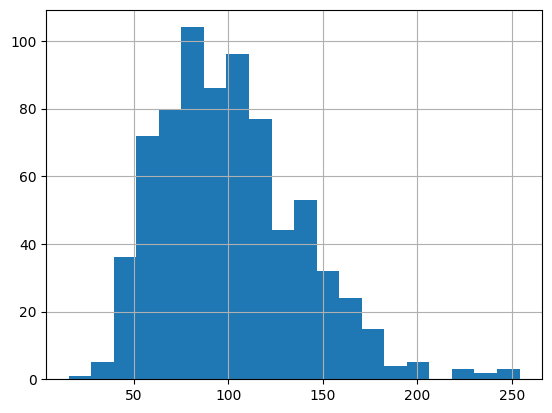

In [9]:
df['Avg Salary(K)'].hist(bins=20)

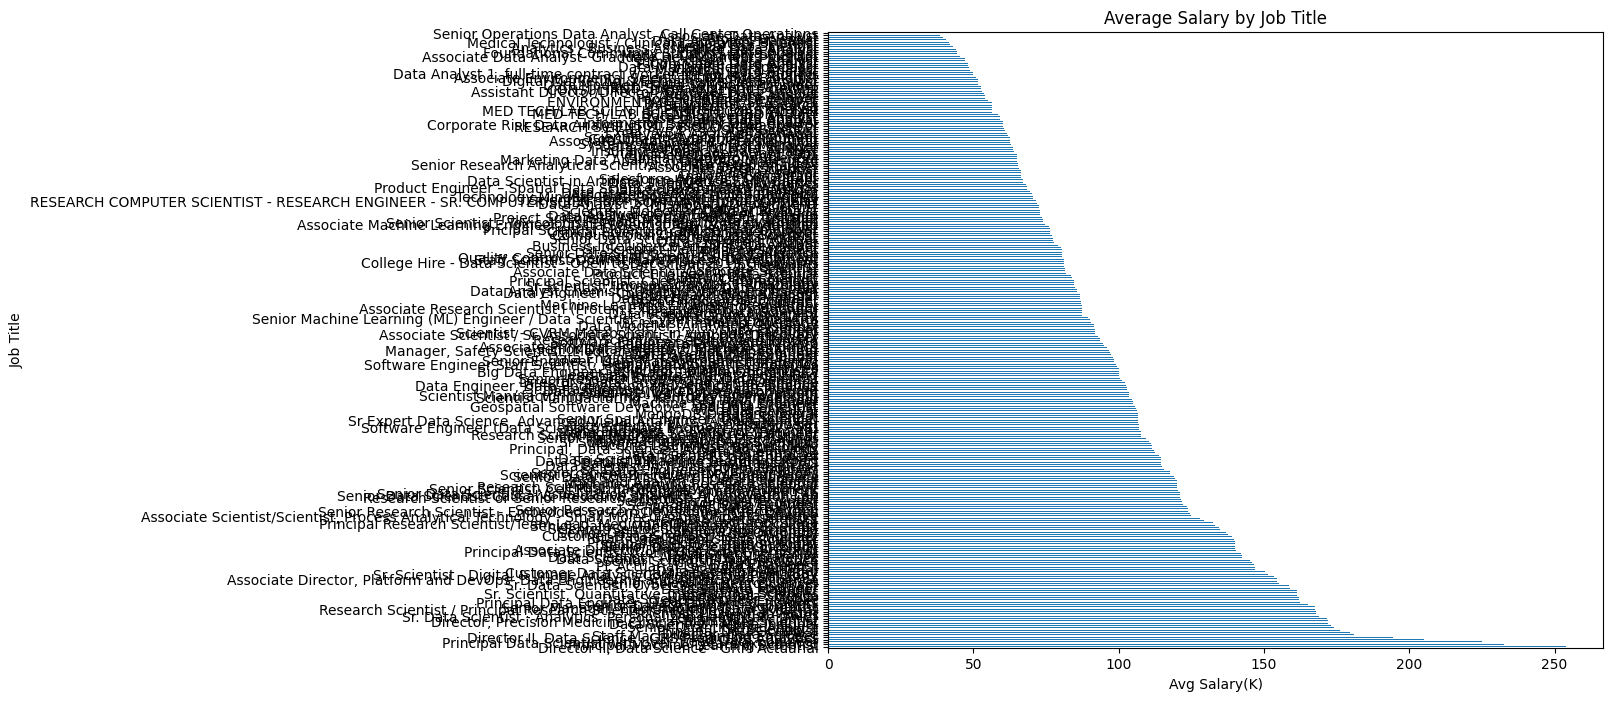

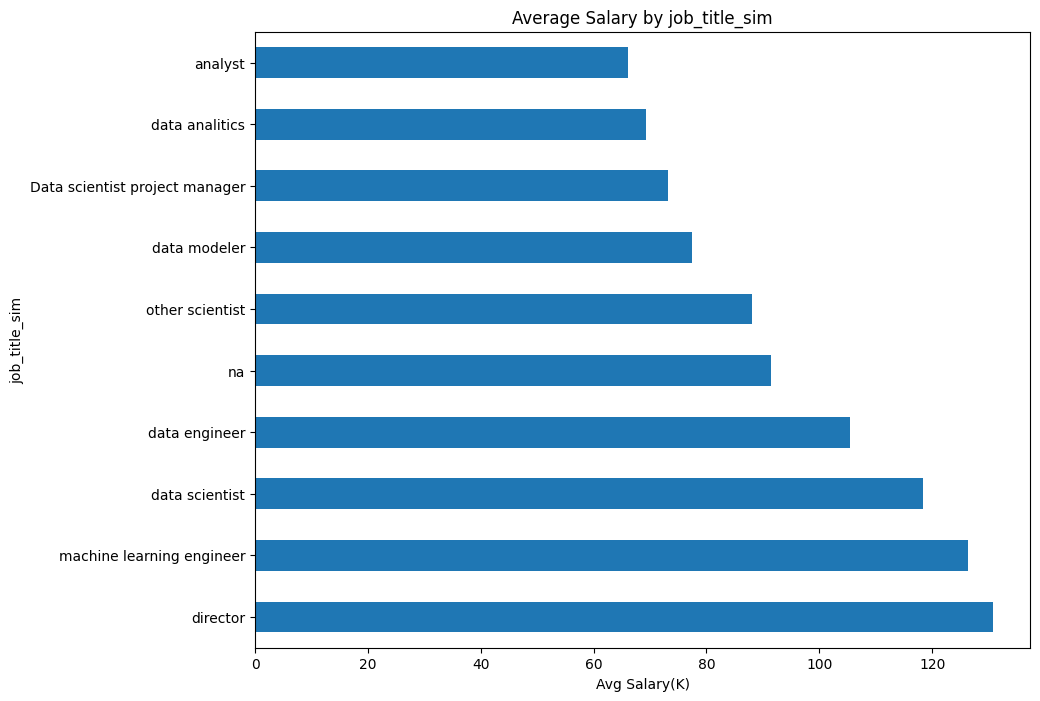

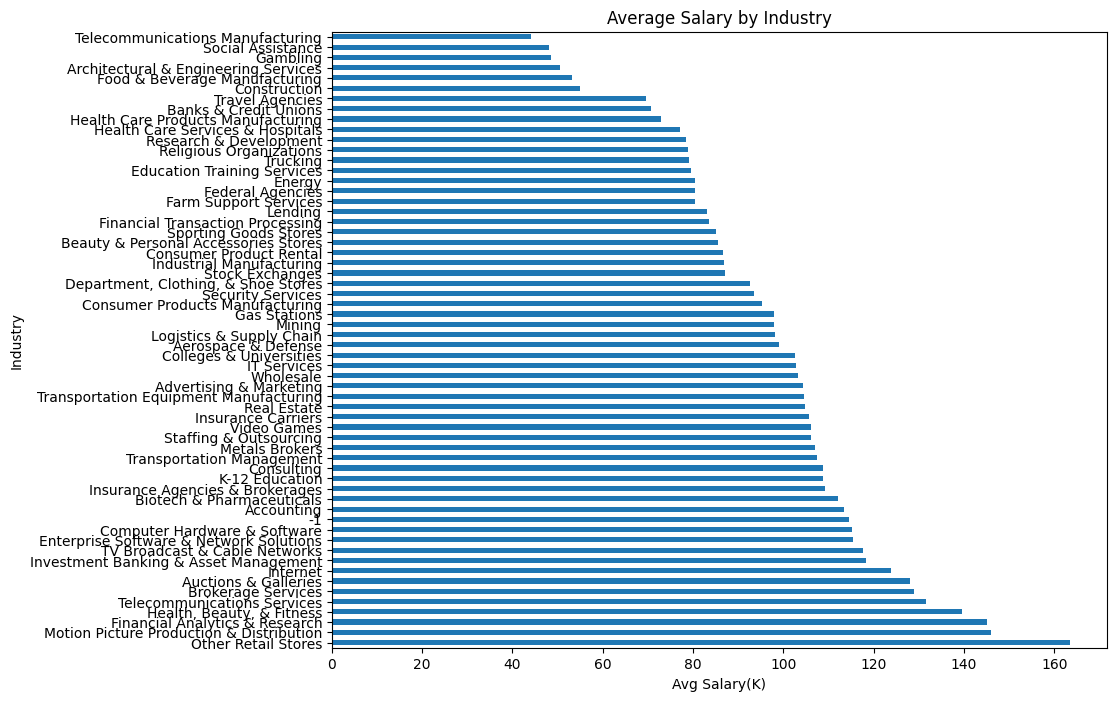

) missing from font(s) DejaVu Sans.rograms\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


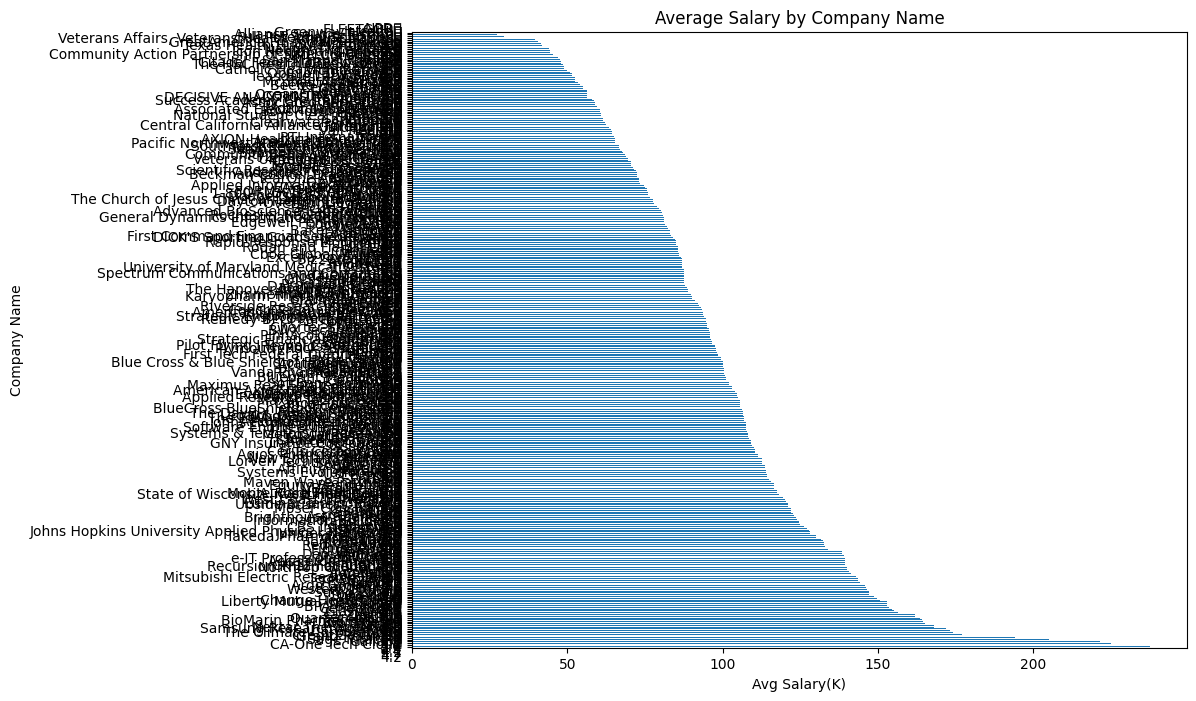

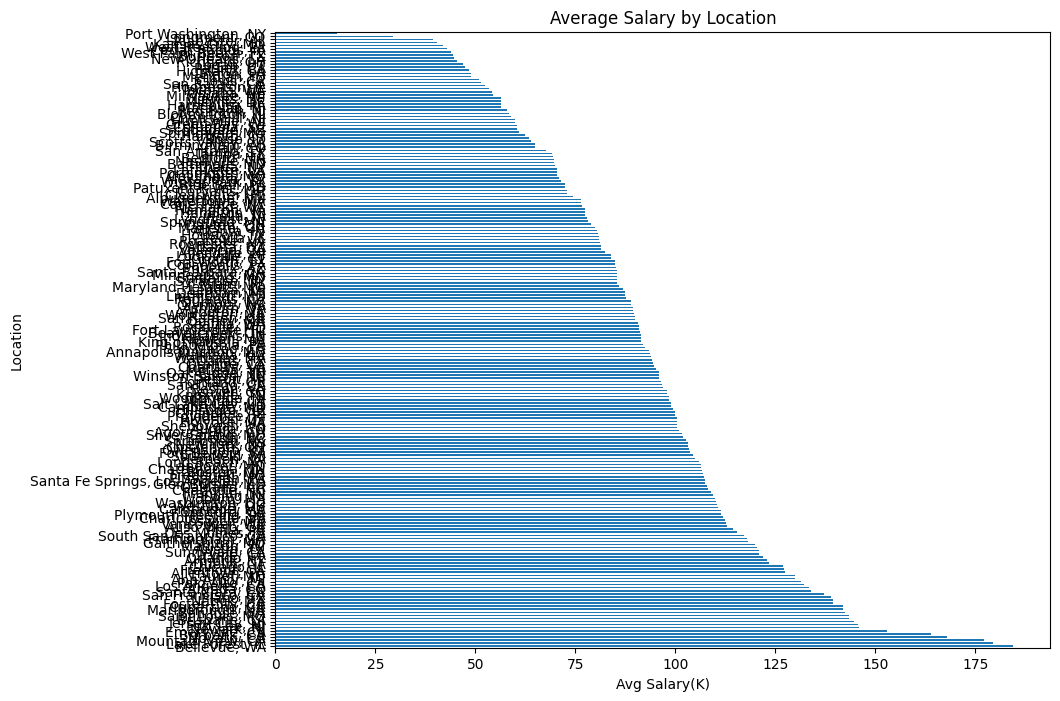

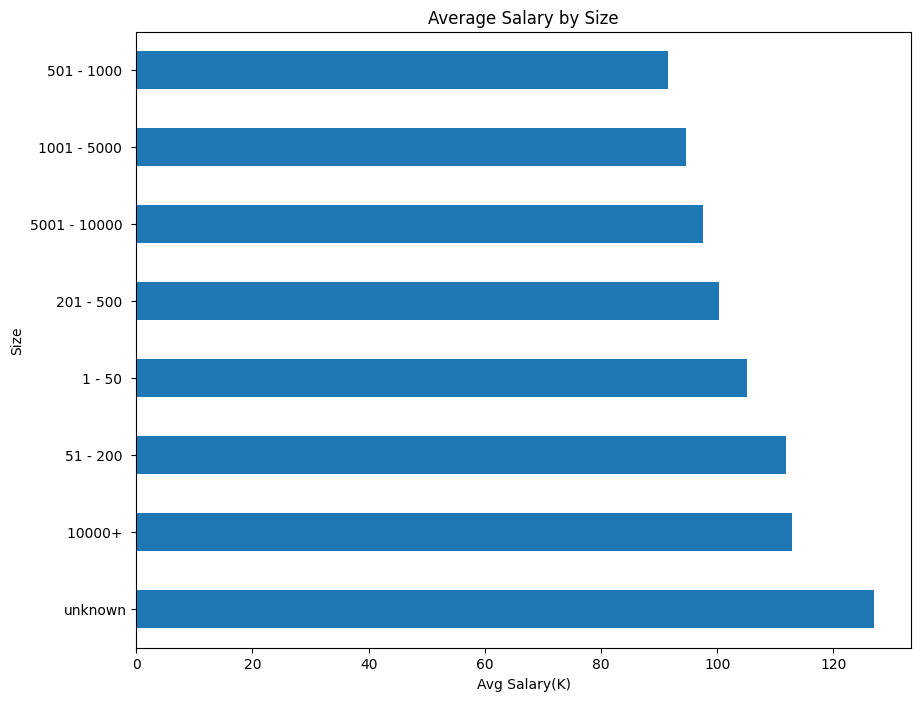

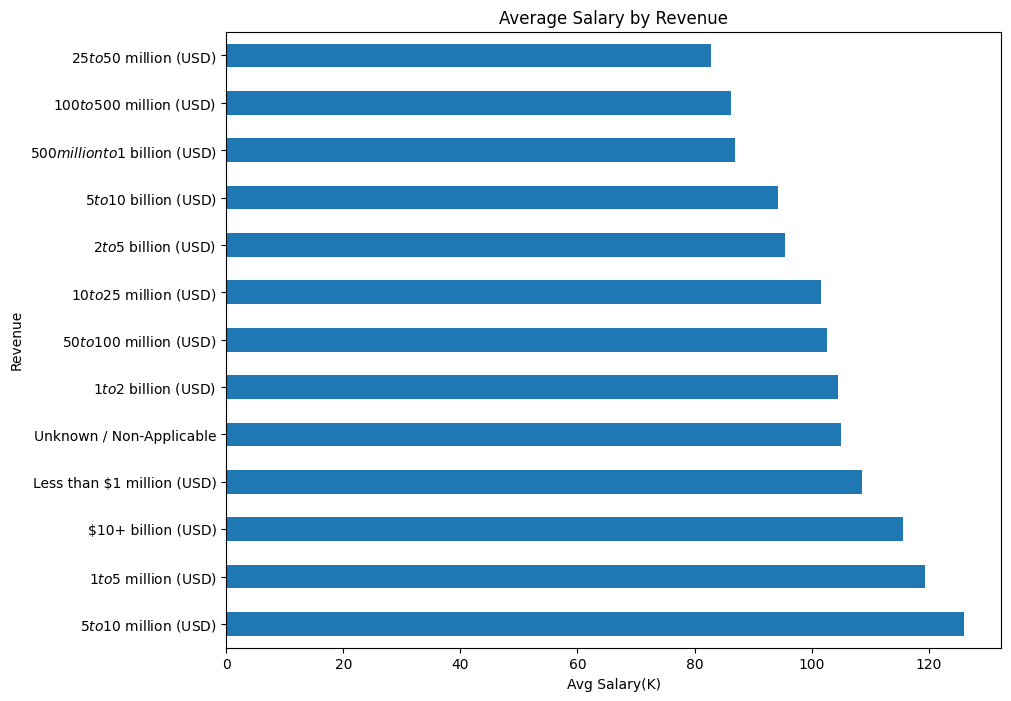

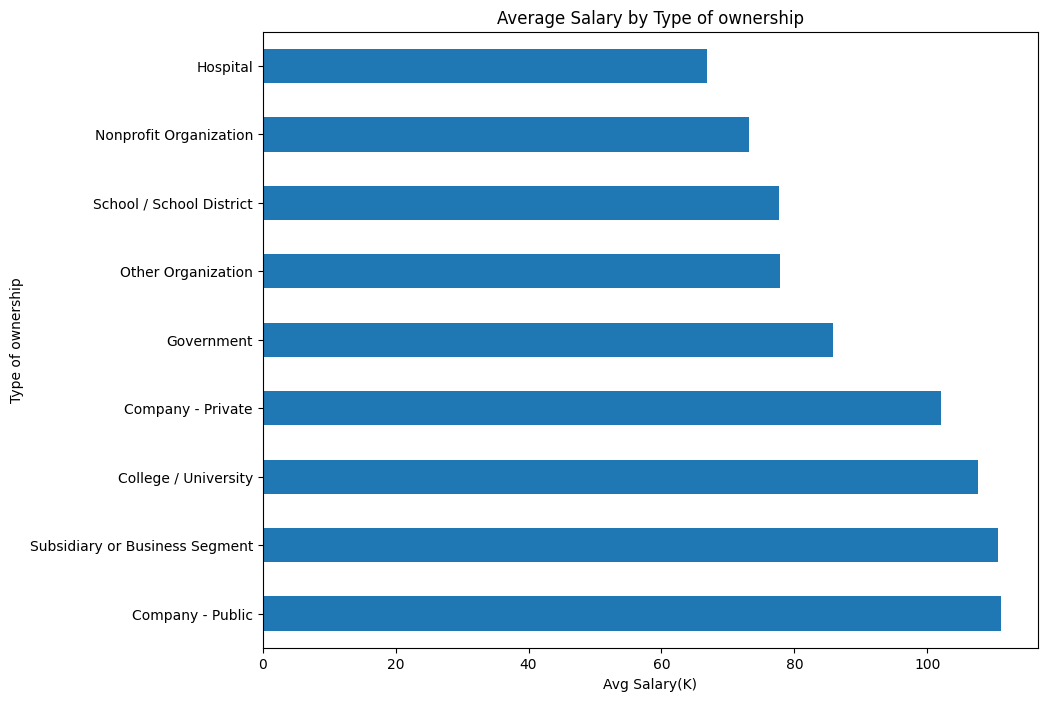

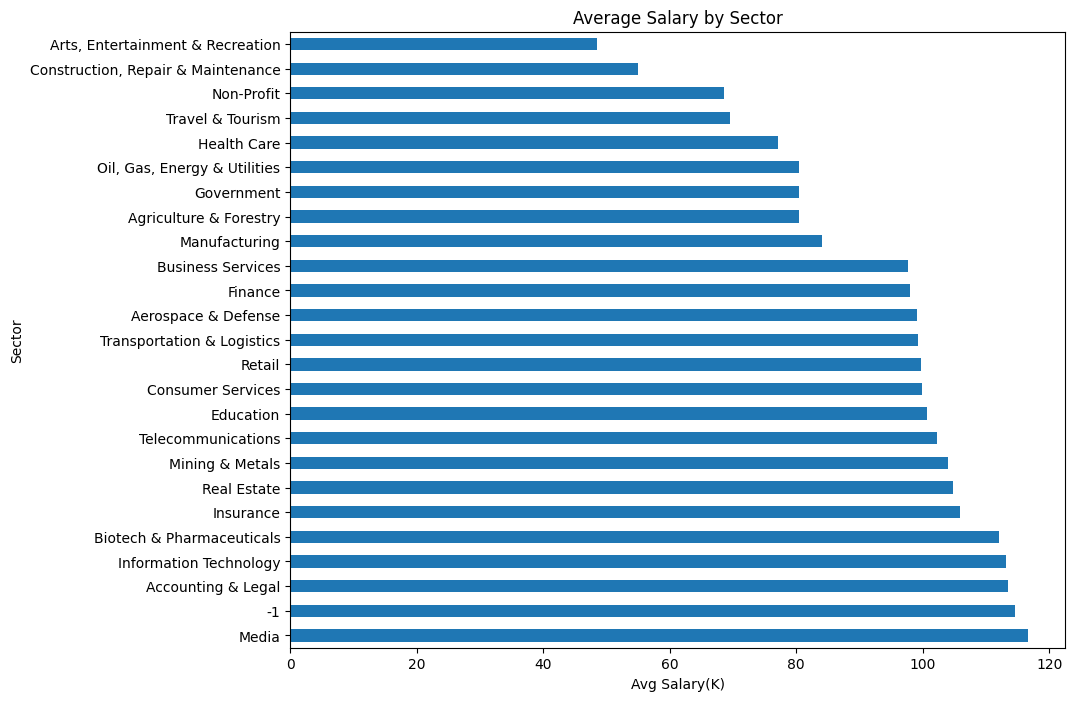

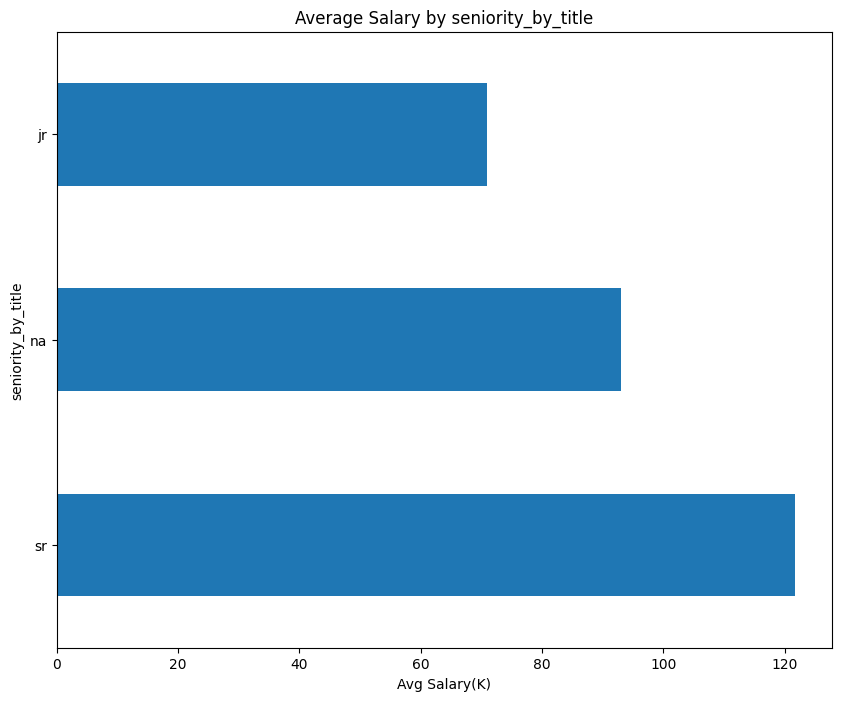

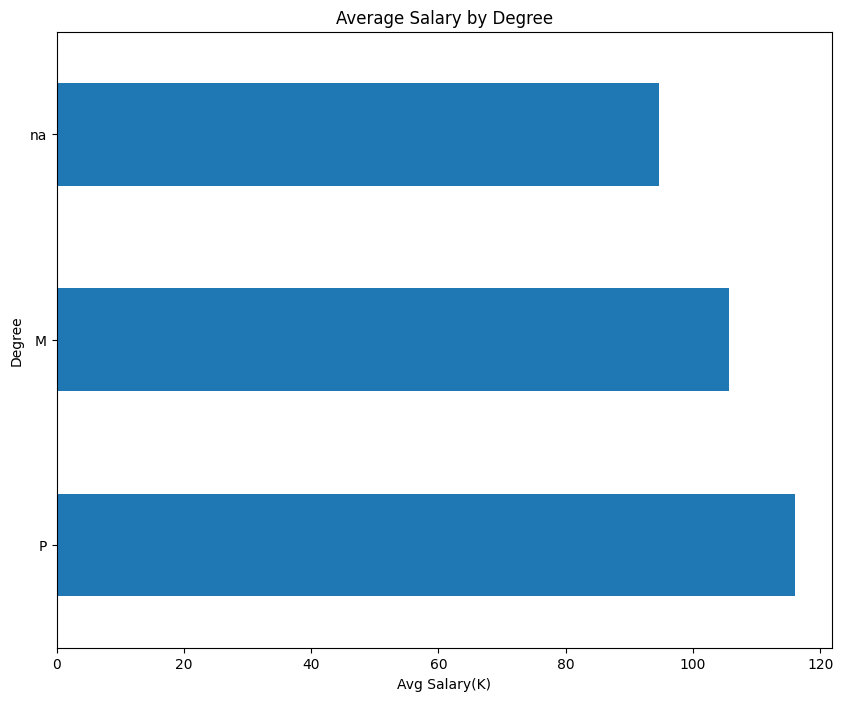

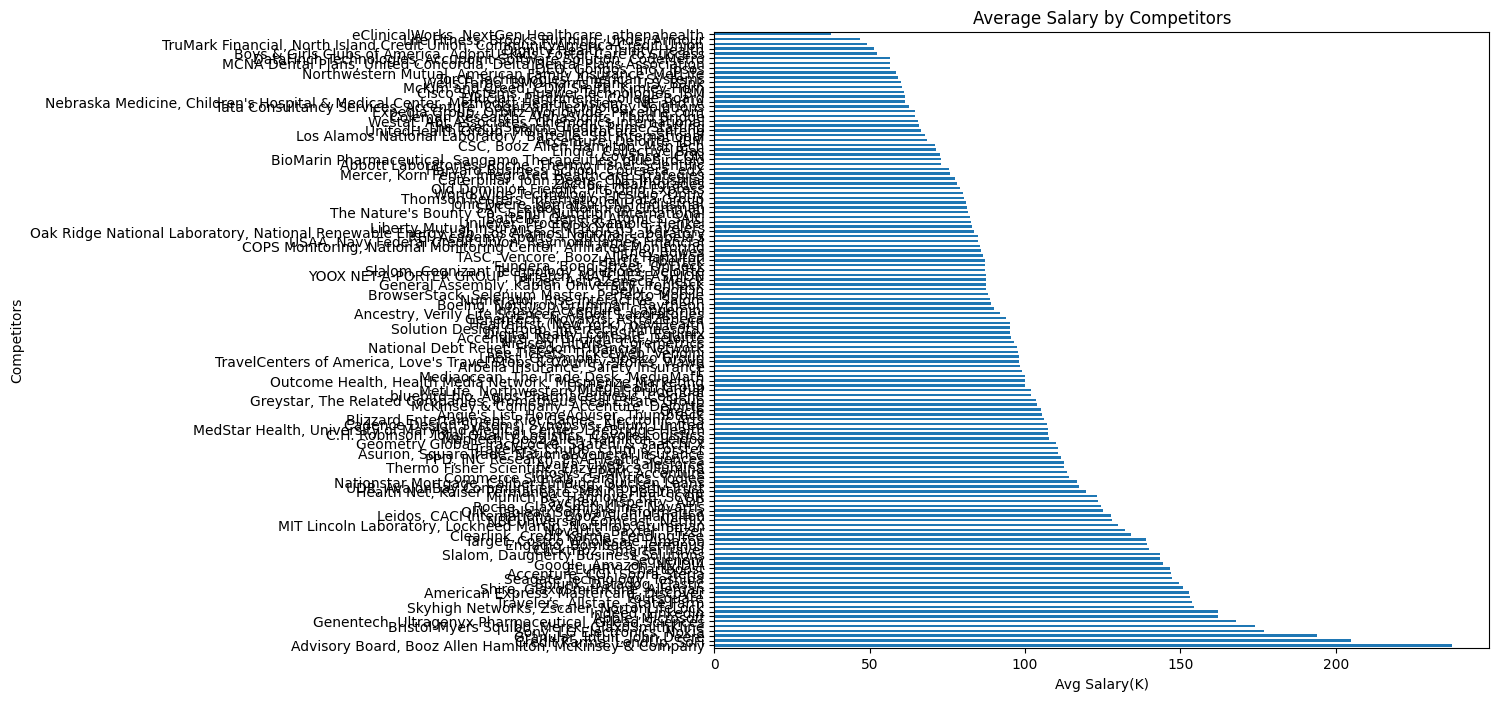

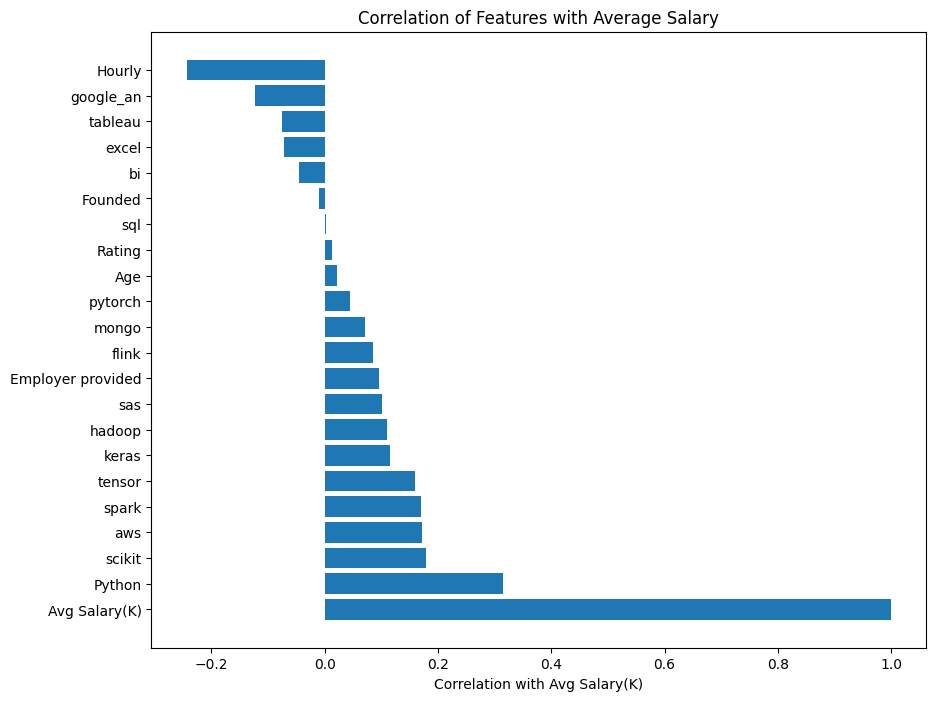

In [10]:
def plot_avg_salary_by_category(df, category_col):
    avg_salary = df.groupby(category_col)['Avg Salary(K)'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    avg_salary.plot(kind='barh')
    plt.title(f'Average Salary by {category_col}')
    plt.xlabel('Avg Salary(K)')
    plt.show()

category_columns = ['Job Title', 'job_title_sim', 'Industry', 'Company Name', 'Location', 'Size', 'Revenue', 'Type of ownership', 'Sector', 'seniority_by_title', 'Degree', 'Competitors']

for category in category_columns:
    plot_avg_salary_by_category(df, category)


skill_columns = ['Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras', 'pytorch',
                 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an']

# Ter certeza de que as colunas de habilidades são do tipo int
df[skill_columns] = df[skill_columns].fillna(0).astype(int)

# Adicionar essas colunas numéricas à análise
df_corr = df[['Avg Salary(K)', 'Rating', 'Founded', 'Age', 'Employer provided', 'Hourly'] + skill_columns]

# Calcular correlação e ordenar
correlation = df_corr.corr()
corr_with_salary = correlation['Avg Salary(K)'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(corr_with_salary.index, corr_with_salary.values)
plt.xlabel('Correlation with Avg Salary(K)')
plt.title('Correlation of Features with Average Salary')
plt.show()


## Pré-processamento e limpeza

### Versão 1

In [3]:
# Como tratar elementos nulos?
df_clean = df.dropna(axis=0)

# Quais colunas devem ser removidas?
features = df_clean.drop(
    columns=[
        'index',            # Índice não é uma feature relevante
        'Salary Estimate',  # Devemos remover por tratar também do target??
        # 'Job Title',        # Devemos remover por ter diferentes formas de escrever o mesmo título?
        # 'Job Description',  # Descrição trata de coisas diferentes podendo não ser interessante para o modelo
        # 'Job Location',     # Temos a informação da localização na coluna 'Location'
        'Lower Salary',     # Devemos remover por tratar também do target??
        'Upper Salary',     # Devemos remover por tratar também do target??
        'Competitors',
        'Rating',           # Devemos remover por não ser relevante para o modelo
        'Founded',          # Devemos remover por não ser relevante para o modelo
        'Avg Salary(K)'     # Devemos remover por ser o target
        ])
target = df_clean['Avg Salary(K)']

# Como tratar colunas categóricas:
features_encoded = pd.get_dummies(features, drop_first=True)

n_features = features_encoded.shape[1]
print("Número de features codificadas:", n_features)



Número de features codificadas: 1983


### Versão 2 (incompleta por enquanto)

In [4]:
# # Colunas numéricas e categóricas
# num_cols = ['experience']
# cat_cols = ['education', 'gender', 'region', 'sector']

# # Colunas a remover (irrelevantes ou derivadas do target)
# drop_cols = [
#     'index',            # Índice não é uma feature relevante
#     'Salary Estimate',  # Devemos remover por tratar também do target??
#     # 'Job Title',        # Devemos remover por ter diferentes formas de escrever o mesmo título?
#     # 'Job Description',  # Descrição trata de coisas diferentes podendo não ser interessante para o modelo
#     # 'Job Location',     # Temos a informação da localização na coluna 'Location'
#     'Lower Salary',     # Devemos remover por tratar também do target??
#     'Upper Salary',     # Devemos remover por tratar também do target??
#     'Competitors',
#     'Rating',           # Devemos remover por não ser relevante para o modelo
#     'Founded',          # Devemos remover por não ser relevante para o modelo
#     'Avg Salary(K)'     # Devemos remover por ser o target
# ]

# features = df.drop(columns=drop_cols)
# target = df['Avg Salary(K)']

# # Transformadores numéricos e categóricos
# num_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])
# cat_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # ColumnTransformer geral
# preprocessor = ColumnTransformer(transformers=[
#     ('num', num_transformer, num_cols),
#     ('cat', cat_transformer, cat_cols)
# ])

## Divisão do dataset em treino e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

## Seleção de features

### Método Filter

In [6]:
selector = SelectKBest(score_func=f_regression, k=50)
selector.fit(X_train, y_train)

scores = pd.Series(selector.scores_, index=X_train.columns)
print(scores.sort_values(ascending=False).head(50))

best_columns = X_train.columns[selector.get_support()]
X_train = X_train[best_columns]

job_title_sim_data scientist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Método Wrapper

In [7]:
# (1) defina um estimador base
est_base = LinearRegression()
# est_base = LassoCV(cv=5, random_state=42, max_iter=5000)

# (2) RFECV: CV de 5 folds tentando de 1 a N features
rfecv = RFECV(
    estimator=est_base,
    step=20,           # remove 1 feature por iteração
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

# 6) Quais features sobreviveram ao RFECV?
mask = rfecv.support_  # boolean mask das features selecionadas
selected_features = X_train.columns[mask]
X_train = X_train[selected_features]
X_test = X_test [selected_features]
print("Número ótimo de features (RFECV):", rfecv.n_features_)
print("Features escolhidas:", list(selected_features))

Número ótimo de features (RFECV): 50
Features escolhidas: ['Hourly', 'Python', 'spark', 'aws', 'scikit', 'tensor', 'Job Title_Data Analyst', 'Job Title_Director II, Data Science - GRM Actuarial', 'Job Title_Lead Data Engineer', 'Job Title_Lead Data Scientist', 'Job Title_Principal Data Scientist', 'Job Title_Senior Data Scientist', "Job Description_Advance your career at Liberty Mutual Insurance - A Fortune 100 Company!\r\n\r\nJob Summary:\r\n\r\nGRM Actuarial - Predictive Modeling team is searching for a highly motivated Director II, Data Science who is eager to make an impact on the very complex and evolving insurance industry. As the manager of the US Short-Tailed Lines Predictive Modeling team, you will provide analytical direction for a team of actuarial and data science professionals. You and your team will leverage primary data, advanced quantitative modeling and financial analysis to develop predictive models and tools that enable data-driven strategic decision-making. This rol

## Treinamento e teste

### Função

In [8]:
def train_and_evaluate(estimator, 
                     param_grid, 
                     X_train, 
                     y_train, 
                     X_test, 
                     y_test):

    # Busca exaustiva de hiperparâmetros
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    
    # Melhor modelo encontrado
    best_estimator = grid.best_estimator_
    
    # Previsões
    y_pred = best_estimator.predict(X_test)
    
    # Cálculo de métricas
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    return {        
        'best_estimator': best_estimator,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'cv_results': grid.cv_results_,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,        
        'r2': r2
    }

### Modelos

#### Ridge

In [9]:
# Regressão Linear com regularização L2
estimator_ridge = Ridge(random_state=42)

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

result_ridge = train_and_evaluate(
    estimator=estimator_ridge,
    param_grid=param_grid_ridge,
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,   
    y_test=y_test
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


#### DecisionTree

In [10]:
estimator_dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
    'max_leaf_nodes': [None, 10, 20, 30]
}

result_dt = train_and_evaluate(
    estimator=estimator_dt,
    param_grid=param_grid_dt,
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,  
    y_test=y_test
)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


#### RandomForest

In [11]:
estimator_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],         # Número de árvores na floresta
    'max_depth': [None, 2, 3, 4],           # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras necessárias em um nó folha
    'max_features': [None, 'sqrt', 'log2'], # Número de recursos a serem considerados ao procurar a melhor divisão
    'ccp_alpha': [0.0, 0.001, 0.01]         # Parâmetro de complexidade para poda   
}

result_rf = train_and_evaluate(
    estimator=estimator_rf,
    param_grid=param_grid_rf,
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,  
    y_test=y_test
)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


## Resultados

### Melhores combinações de hiperparâmetros

In [101]:
# Imprime melhores parâmetros, melhor score e top N combos de hiperparâmetros
def print_search_results(result, model_name, top_n=3):
    print(
        f"Modelo {model_name} \n\n"
        f"Melhores parâmetros: {result['best_params']} \n"
        f"Melhor score médio: {result['best_score']:.4f} \n\n"
        f"Top {top_n} combinações de hiperparâmetros:"
    )
    df = pd.DataFrame(result['cv_results'])
    display(df.sort_values(by='mean_test_score', ascending=False).head(top_n))

In [102]:
print_search_results(result_ridge, "Ridge")

Modelo Ridge 

Melhores parâmetros: {'alpha': 0.1} 
Melhor score médio: -25.1783 

Top 3 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009404,0.004626,0.002630,0.000980,0.1,{'alpha': 0.1},-25.594524,-24.137329,-26.008561,-25.538936,-24.611913,-25.178253,0.692394,1
1,0.007563,0.000822,0.003129,0.000410,1.0,{'alpha': 1.0},-25.618934,-24.537615,-26.414402,-25.047498,-24.550986,-25.233887,0.711022,2
2,0.006755,0.002093,0.002353,0.000487,10.0,{'alpha': 10.0},-25.554970,-26.652622,-28.010434,-24.900363,-24.984750,-26.020628,1.175042,3


In [103]:
print_search_results(result_dt, "DecisionTree")

Modelo DecisionTree 

Melhores parâmetros: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10} 
Melhor score médio: -24.3831 

Top 3 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1622,0.006493,0.000313,0.00291,0.000230,0.010,None,None,None,1,10,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",-22.454473,-22.922334,-27.782685,-25.882864,-22.873246,-24.38312,2.094735,1
2,0.008781,0.000894,0.00456,0.001236,0.000,None,None,None,1,10,"{'ccp_alpha': 0.0, 'max_depth': None, 'max_fea...",-22.454473,-22.922334,-27.781820,-25.885678,-22.873246,-24.38351,2.094857,2
542,0.006891,0.001182,0.00378,0.001007,0.001,None,None,None,1,10,"{'ccp_alpha': 0.001, 'max_depth': None, 'max_f...",-22.454473,-22.922334,-27.781820,-25.885678,-22.873246,-24.38351,2.094857,2


In [104]:
print_search_results(result_rf, "RandomForest")

Modelo RandomForest 

Melhores parâmetros: {'ccp_alpha': 0.001, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 
Melhor score médio: -21.4493 

Top 3 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
380,0.477488,0.017879,0.020703,0.000798,0.001,None,log2,1,2,200,"{'ccp_alpha': 0.001, 'max_depth': None, 'max_f...",-21.309672,-20.685227,-22.681080,-21.507072,-21.063314,-21.449273,0.674227,1
56,0.530248,0.023397,0.027268,0.005109,0.000,None,log2,1,2,200,"{'ccp_alpha': 0.0, 'max_depth': None, 'max_fea...",-21.309947,-20.685277,-22.681550,-21.507174,-21.063141,-21.449418,0.674397,2
704,0.467225,0.009020,0.023174,0.001338,0.010,None,log2,1,2,200,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",-21.310139,-20.684223,-22.682317,-21.505627,-21.064865,-21.449434,0.674685,3


### Medidas de desempenho

In [20]:
def print_metrics(result, model_name):         
        print(
            f"{model_name} → "            
            f"| MAE: {result['mae']:.2f} "
            f"| RMSE: {result['rmse']:.2f} "
            f"| R²: {result['r2']:.4f} |"
        )

for name, result in [
    ("Ridge", result_ridge),
    ("DT", result_dt),
    ("RF", result_rf)
]:
    print_metrics(result, name)

Ridge → | MAE: 20.11 | RMSE: 25.86 | R²: 0.5735 |
DT → | MAE: 17.96 | RMSE: 24.59 | R²: 0.6144 |
RF → | MAE: 14.47 | RMSE: 20.53 | R²: 0.7314 |


### Gráficos

#### Reais vs Preditos

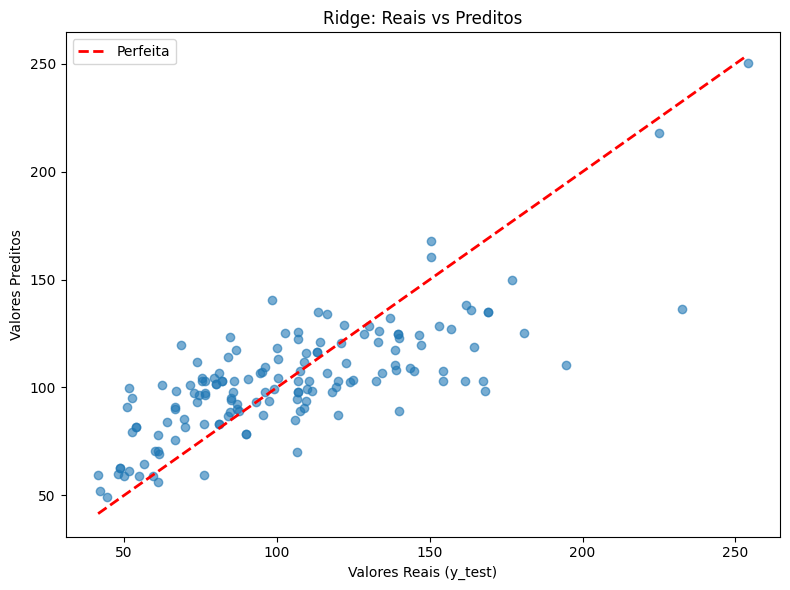

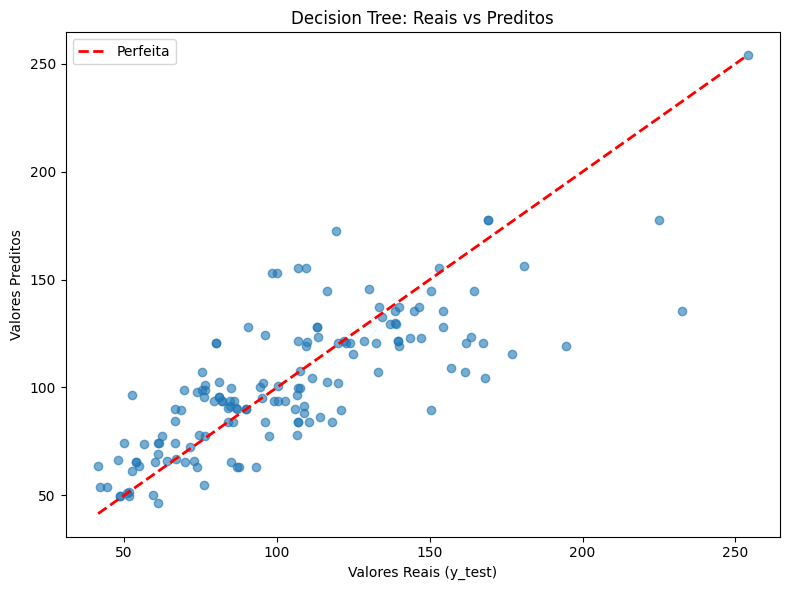

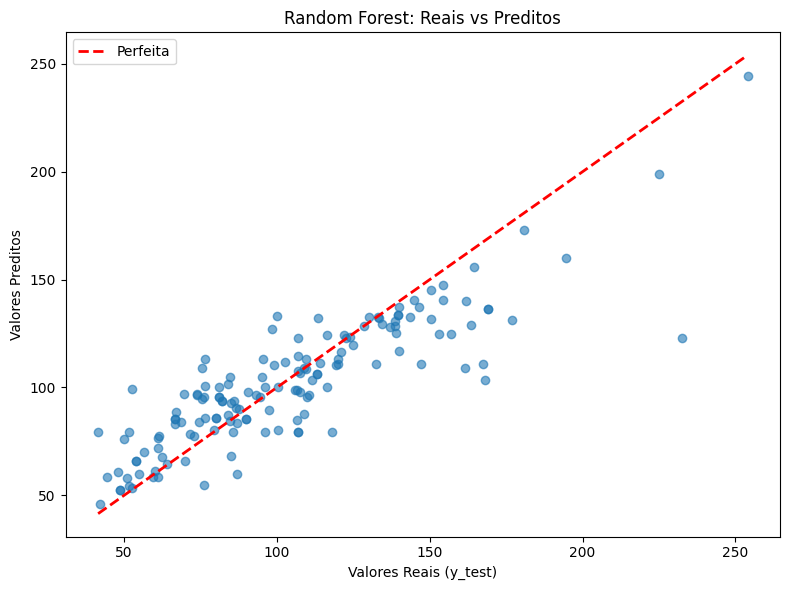

In [12]:
def plot_predicted_vs_actual(result, model_name, y_test):
    y_pred = result['y_pred']
    
    # Scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Linha identidade
    lim_min = min(y_test.min(), y_pred.min())
    lim_max = max(y_test.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', lw=2, label='Perfeita')

    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name}: Reais vs Preditos")
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_predicted_vs_actual(result, name, y_test)

#### Resíduos vs Preditos

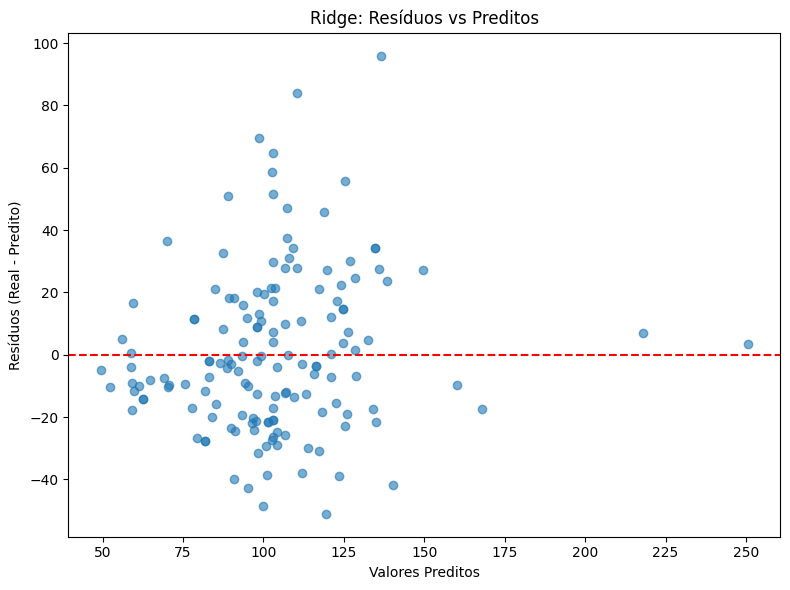

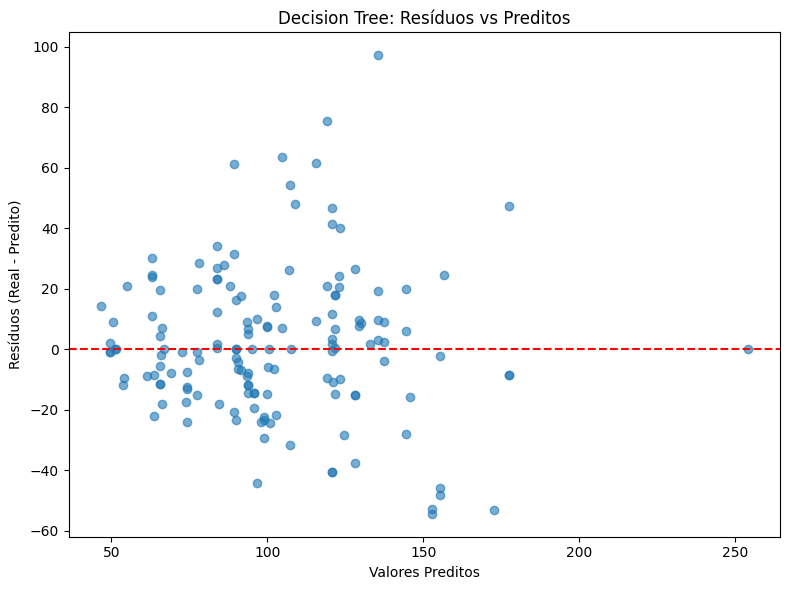

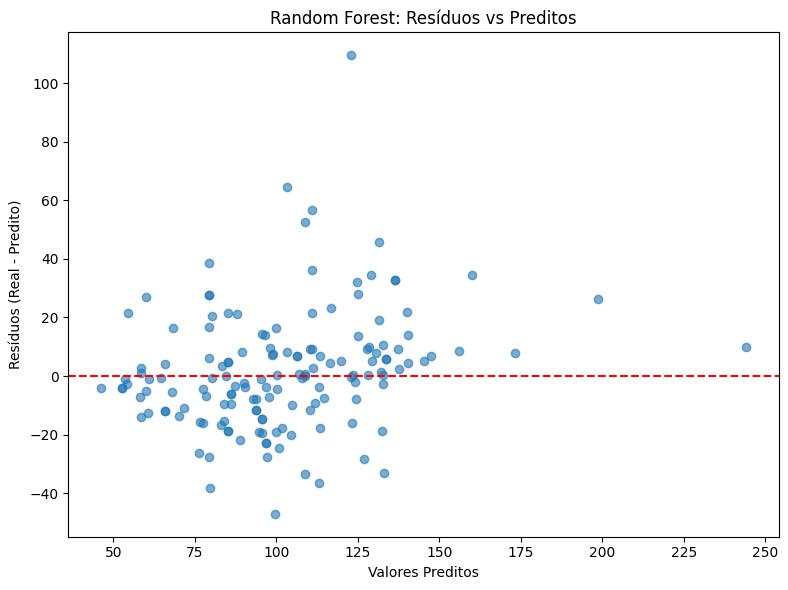

In [13]:
def plot_residuals(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred

    # Scatter
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.6)

    plt.axhline(y=0, color='red', linestyle='--')

    plt.xlabel("Valores Preditos")
    plt.ylabel("Resíduos (Real - Predito)")
    plt.title(f"{model_name}: Resíduos vs Preditos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_residuals(result, name, y_test)

#### Importância de Features

##### Árvores/Floresta (DecisionTree/RandomForest)

) missing from font(s) DejaVu Sans.emp\ipykernel_11240\1567286240.py:24: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.rograms\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


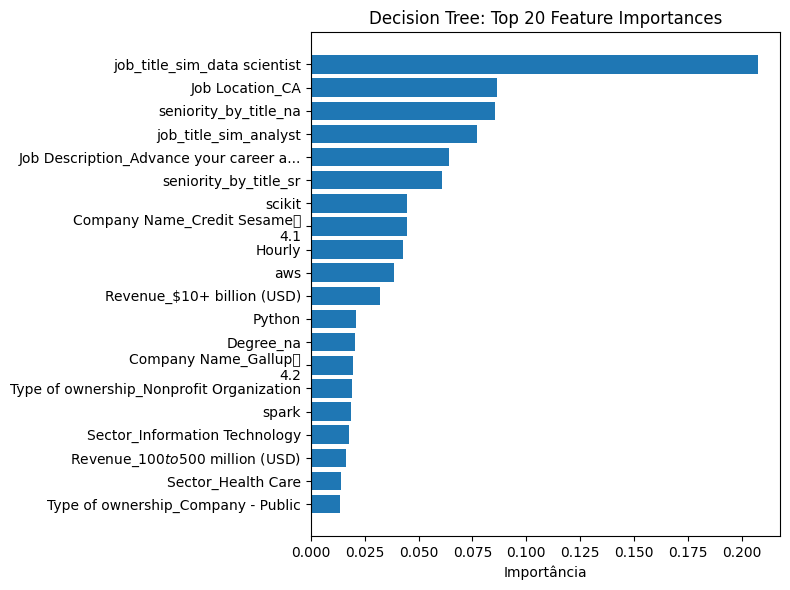

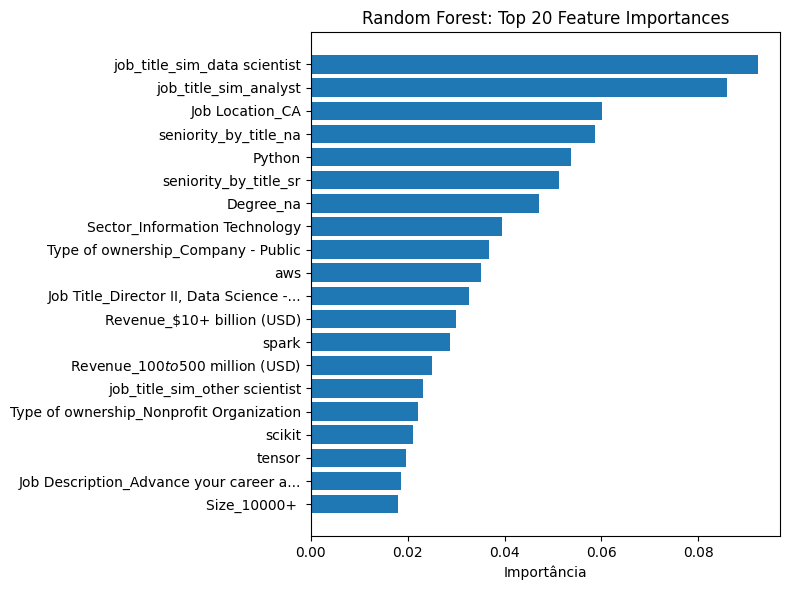

In [29]:
def plot_feature_importances(result, model_name, top_n=20, text_max_len=40):
    model = result['best_estimator']

    # Só árvores e ensembles têm feature_importances_
    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} não tem 'feature_importances_'; pulando.")
        return

    names = list(model.feature_names_in_)
    importances = model.feature_importances_
    idx = np.argsort(importances)[-top_n:]

    # Trunca os nomes longos
    labels = [
        (names[i] if len(names[i]) <= text_max_len 
         else names[i][:text_max_len-3] + "...")
        for i in idx
    ]
    
    plt.figure(figsize=(8,6))
    plt.barh(range(top_n), importances[idx], tick_label=labels)
    plt.xlabel("Importância")
    plt.title(f"{model_name}: Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_feature_importances(result, name)

##### Modelos lineares (Lasso/Ridge)

) missing from font(s) DejaVu Sans.emp\ipykernel_11240\3452810134.py:24: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.rograms\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


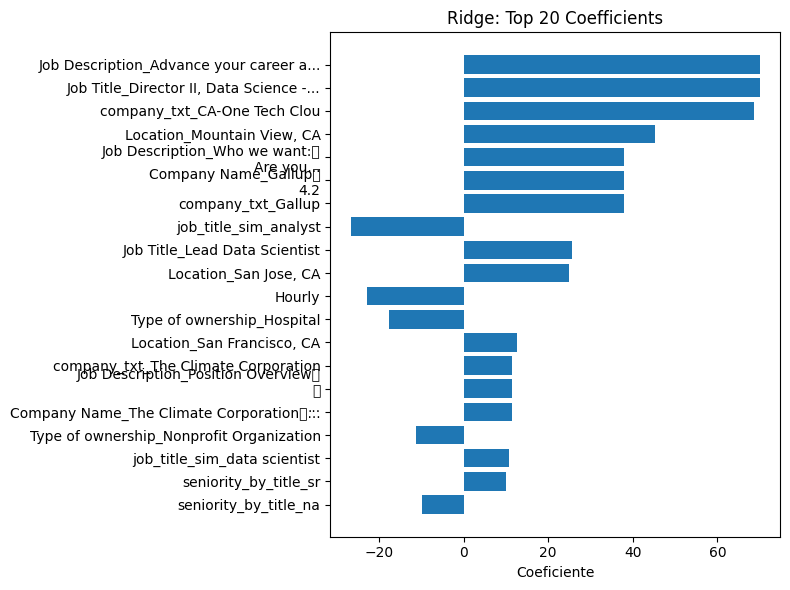

In [30]:
def plot_coefficients(result, model_name, top_n=20, text_max_len=40):
    model = result['best_estimator']

    # Só modelos lineares têm coef_
    if not hasattr(model, "coef_"):
        print(f"{model_name} não tem 'coef_'; pulando.")
        return

    names = list(model.feature_names_in_)
    coefs = model.coef_
    idx = np.argsort(np.abs(coefs))[-top_n:]

    # Trunca os nomes longos
    labels = [
        (names[i] if len(names[i]) <= text_max_len 
         else names[i][:text_max_len-3] + "...")
        for i in idx
    ]

    plt.figure(figsize=(8,6))    
    plt.barh(range(top_n), coefs[idx], tick_label=labels)
    plt.xlabel("Coeficiente")
    plt.title(f"{model_name}: Top {top_n} Coefficients")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
]:
    plot_coefficients(result, name)

#### Distribuição dos resíduos

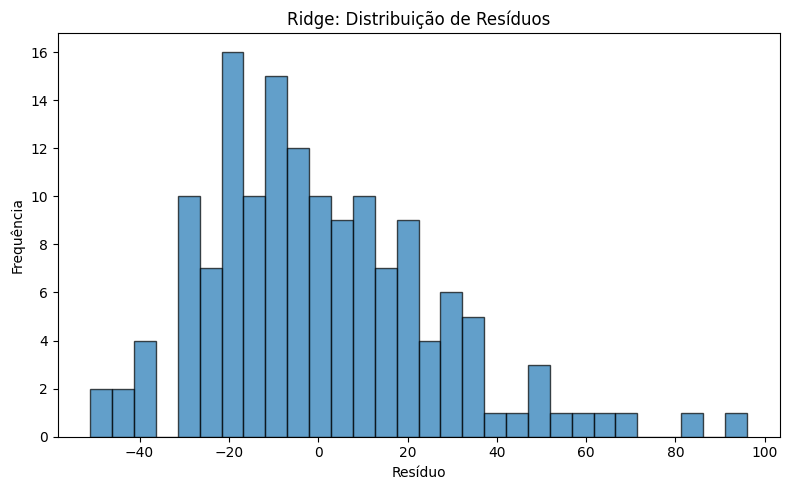

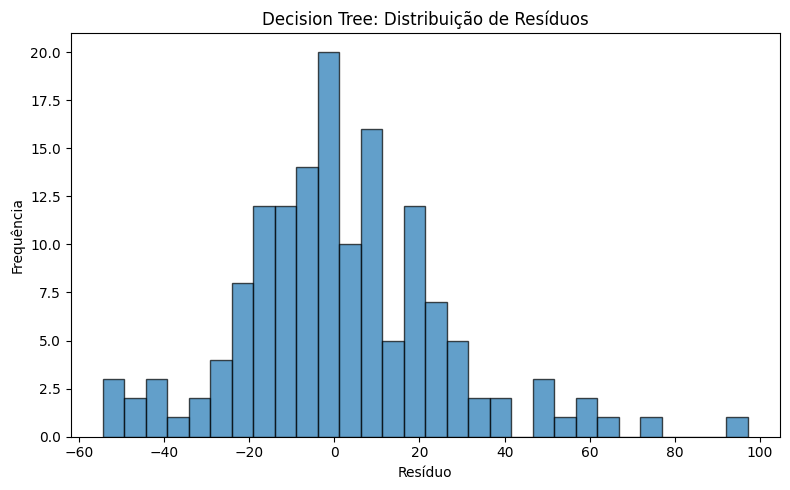

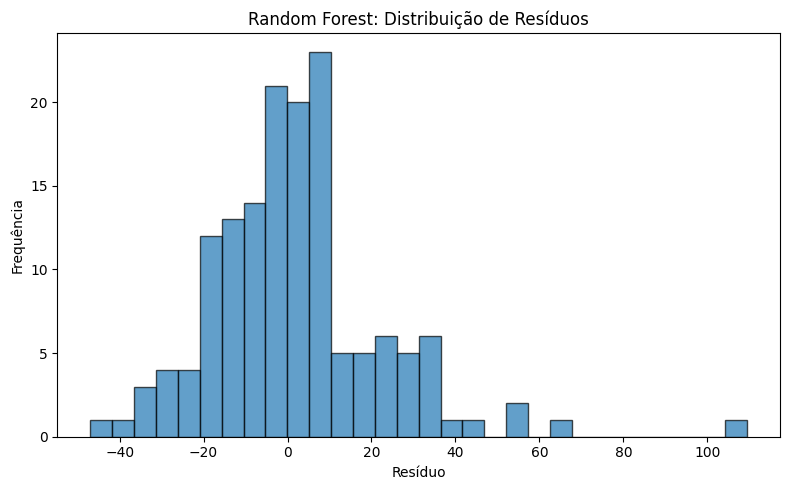

In [ ]:
def plot_residuals_hist(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    plt.figure(figsize=(8,5))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.title(f"{model_name}: Distribuição de Resíduos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_residuals_hist(result, name, y_test)

#### Partial Dependence Plot

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


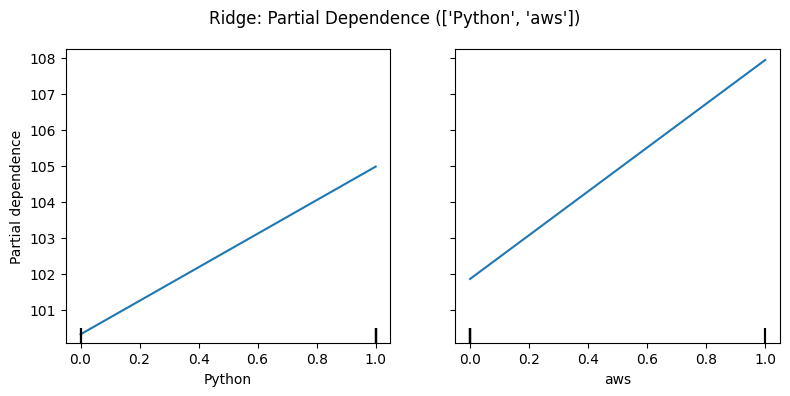

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


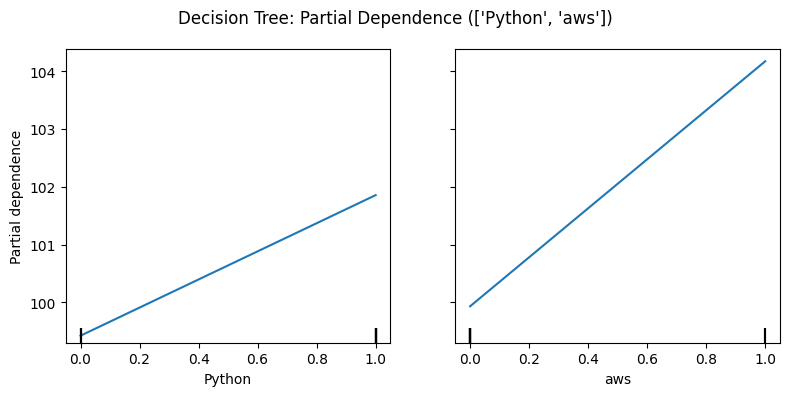

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


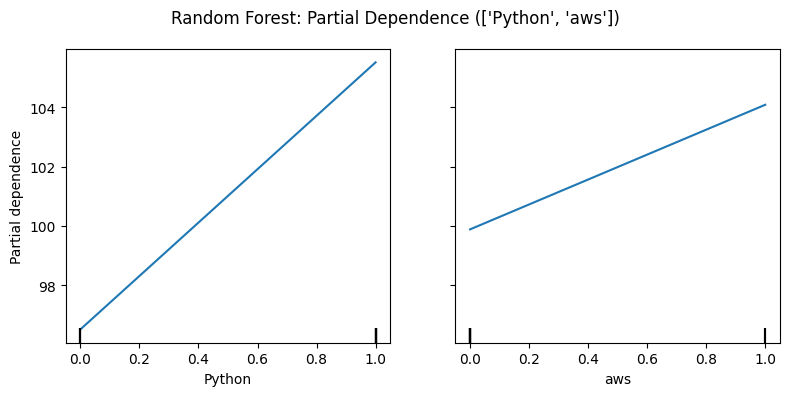

In [32]:
def plot_partial_dependence(result, model_name, X_test, features, grid_resolution=50):
    model = result['best_estimator']
    
    # Só plota se o modelo suportar predict (quase todo regressor com PDP)
    if not hasattr(model, "predict"):
        print(f"{model_name} não suporta PDP; pulando.")
        return

    # Se receber nomes de colunas, converter para índices
    feat = []
    for f in features:
        if isinstance(f, str):
            feat.append(list(X_test.columns).index(f))
        else:
            feat.append(f)


    fig, ax = plt.subplots(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        model, X_test, features=feat, ax=ax, grid_resolution=grid_resolution
    )
    plt.suptitle(f"{model_name}: Partial Dependence ({features})")
    plt.tight_layout()
    plt.show()

# Ou usando nomes de feature diretamente:
for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_partial_dependence(
        result, name, X_test, features=['Python', 'aws'], grid_resolution=50
    )

#### Pairplot

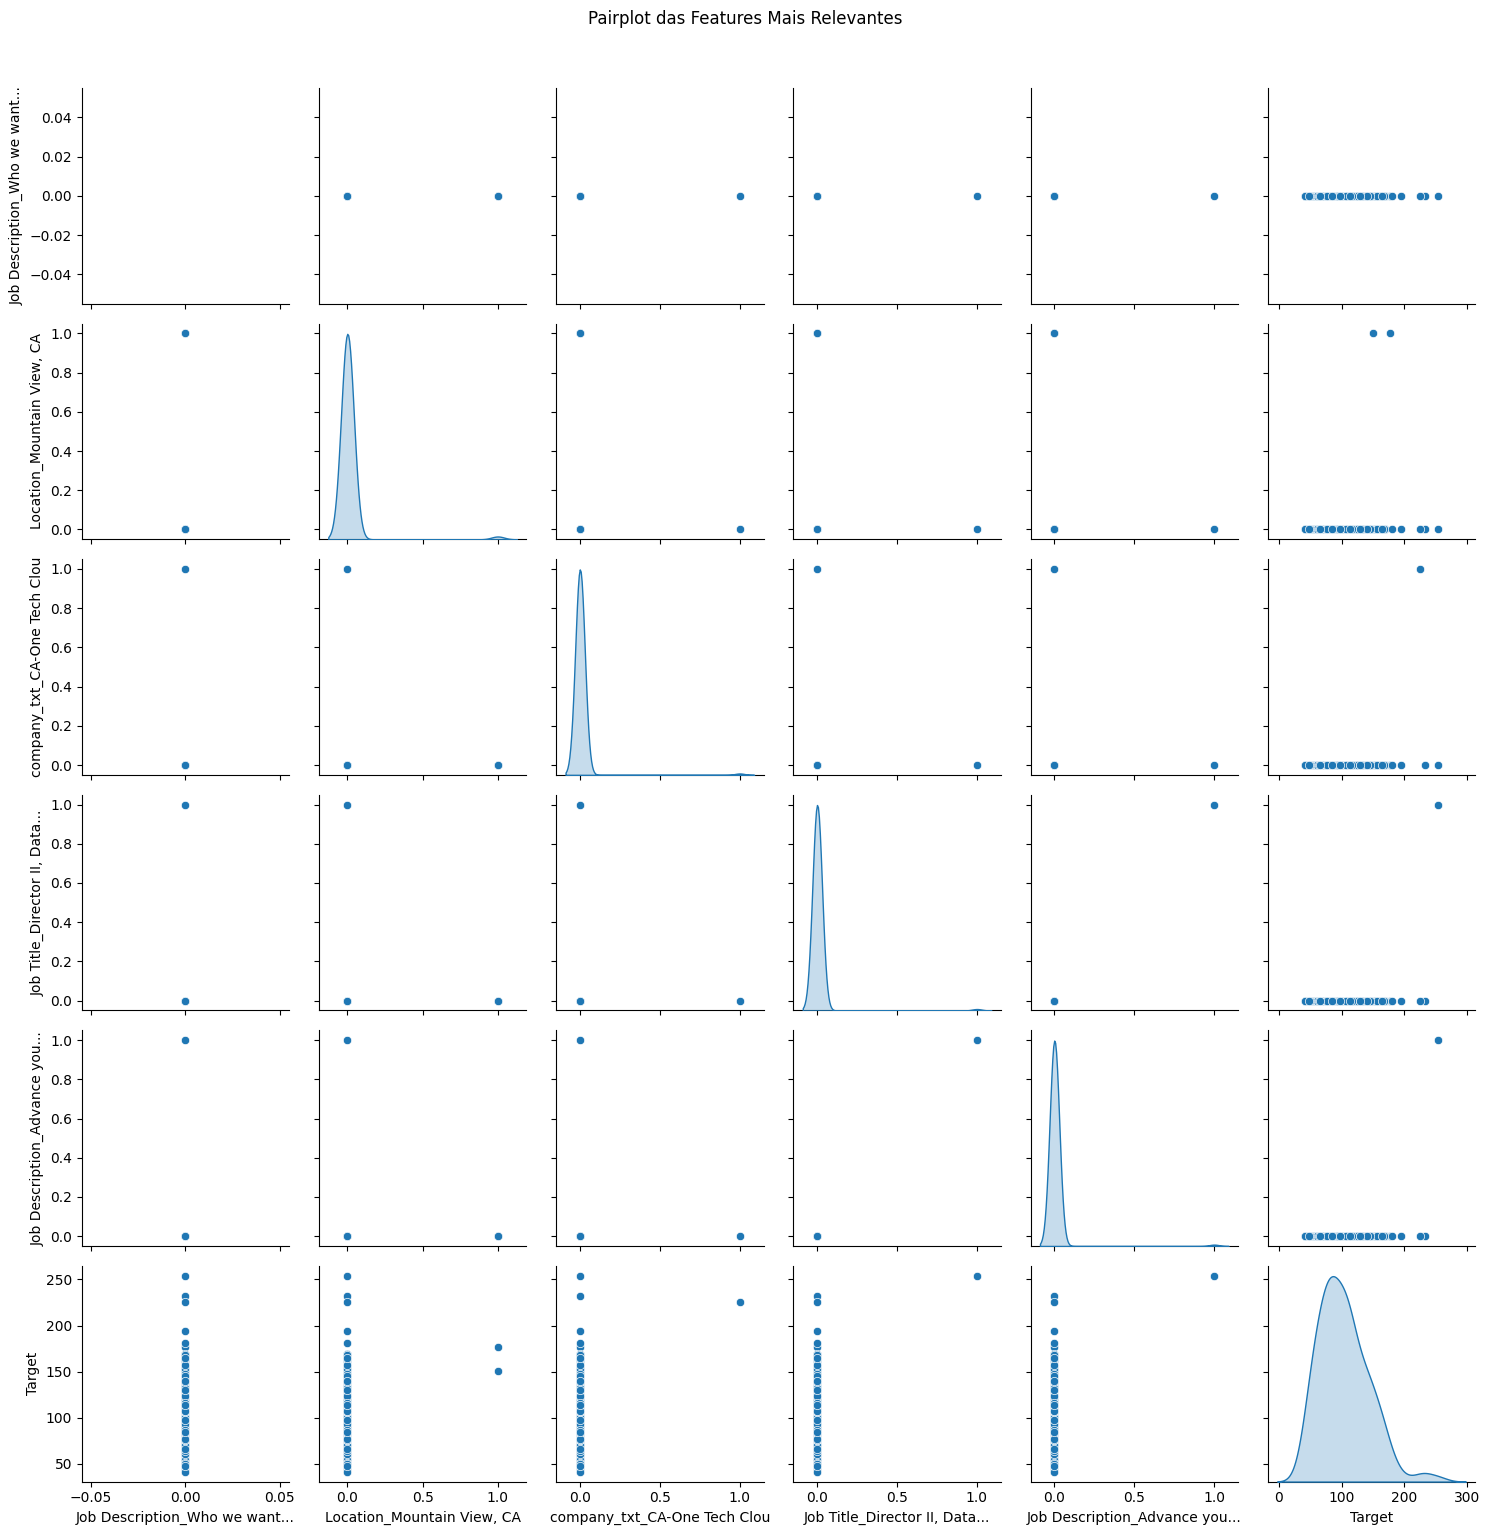

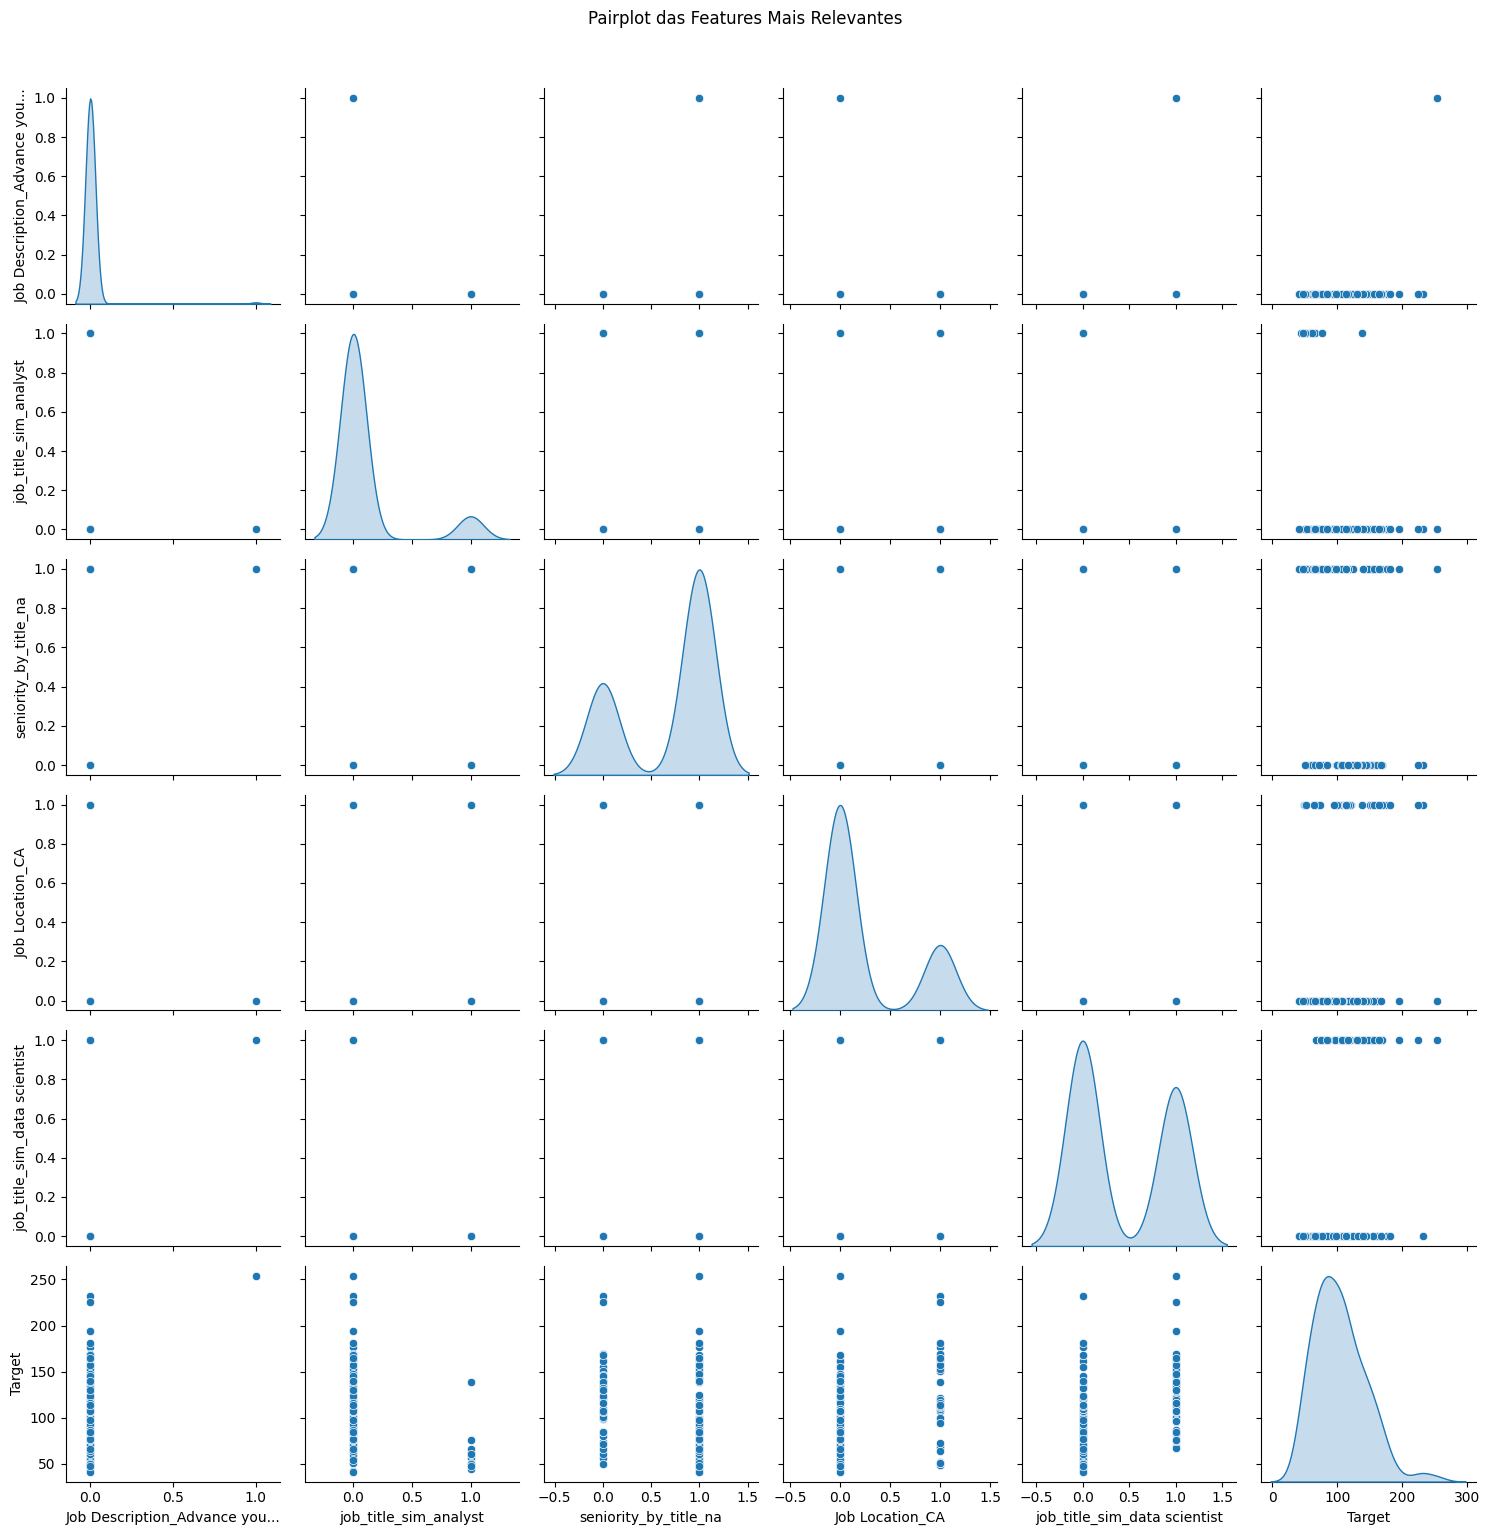

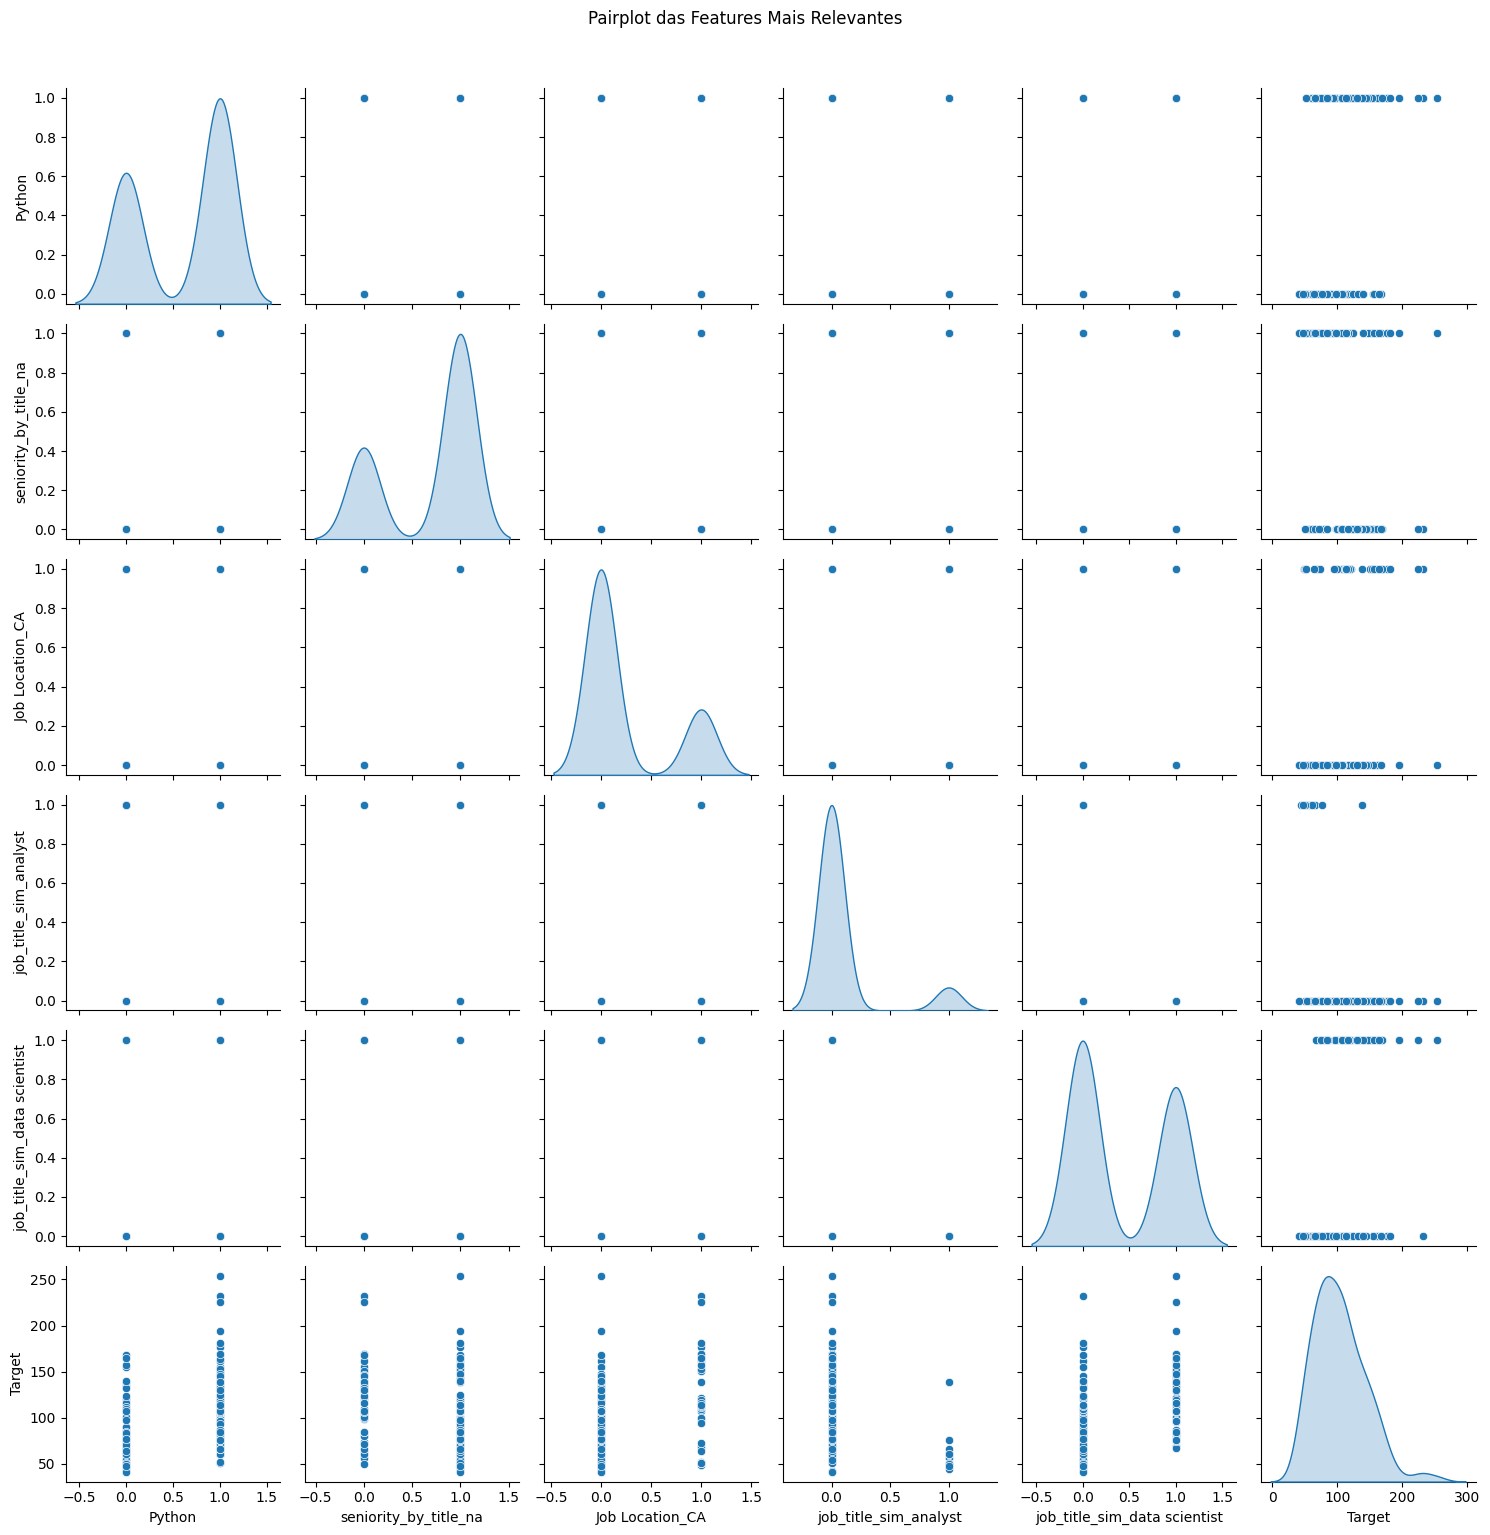

In [38]:
def plot_pairplot(result, X_test, y_test, top_n=5, text_max_len=30):    
    model = result["best_estimator"]
    
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_)
    else:
        print("Modelo não tem importâncias/coefs acessíveis.")
        return

    names = model.feature_names_in_
    idx = np.argsort(importances)[-top_n:]
    selected_features = [names[i] for i in idx]

    # Truncar nomes longos
    truncated_names = [
        (name if len(name) <= text_max_len else name[:text_max_len - 3] + "...")
        for name in selected_features
    ]

    # Criar um DataFrame com essas features + target
    data_plot = pd.DataFrame(X_test[selected_features].values, columns=truncated_names)
    data_plot["Target"] = y_test.values

    # Plotar
    sns.pairplot(data_plot, diag_kind="kde")
    plt.suptitle("Pairplot das Features Mais Relevantes", y=1.02)
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_pairplot(result, X_test, y_test)